In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Configs
folder_path = 'measurements/mock/Q1a'
columns_to_keep = ['QPS', 'p95']

In [3]:
# Function to read data from .raw files and onrganize them in convenient dictionaries
def read_data_CiTi(folder_path, columns_to_keep):
    data_dict = dict()
    for subpath in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, subpath)):
            subfolder_path = os.path.join(folder_path, subpath)
            subfolder_data = dict()
            for file in os.listdir(subfolder_path):
                if (not file.endswith('run0.raw')):
                    file_path = os.path.join(subfolder_path, file)
                    run_name = file.split(".")[0]
                    with open(file_path, 'r') as f:
                        skipfooter_cnt = 0
                        for line in f.readlines():
                            if not (line.startswith('read') or line.startswith('#type')):
                                skipfooter_cnt +=1
                    df = pd.read_csv(file_path, sep=r'\s+', usecols=columns_to_keep, skipfooter=skipfooter_cnt, engine='python')
                    df['p95'] = df['p95']/1000      #from microseconds to ms
                    subfolder_data[run_name] = df
            data_dict[subpath] = subfolder_data
    return data_dict


# Function to compute metrics for each CiTi (avg and std)
def compute_CiTi_metrics(data_dict):
    metrics_dict = dict()
    for CiTi, runs_data in data_dict.items():
        concatenated = pd.concat(runs_data.values(), axis=1)
        metrics_dict[CiTi] = pd.DataFrame({'avg_p95': concatenated['p95'].mean(axis=1), 
                                    'avg_QPS': concatenated['QPS'].mean(axis=1), 
                                    'std_p95': concatenated['p95'].std(axis=1), 
                                    'std_QPS': concatenated['QPS'].std(axis=1)})
    return metrics_dict



In [4]:
# Load data
data = read_data_CiTi(folder_path, columns_to_keep)

# Get metrics to plot (avgs and stds)
metrics_dict = compute_CiTi_metrics(data)

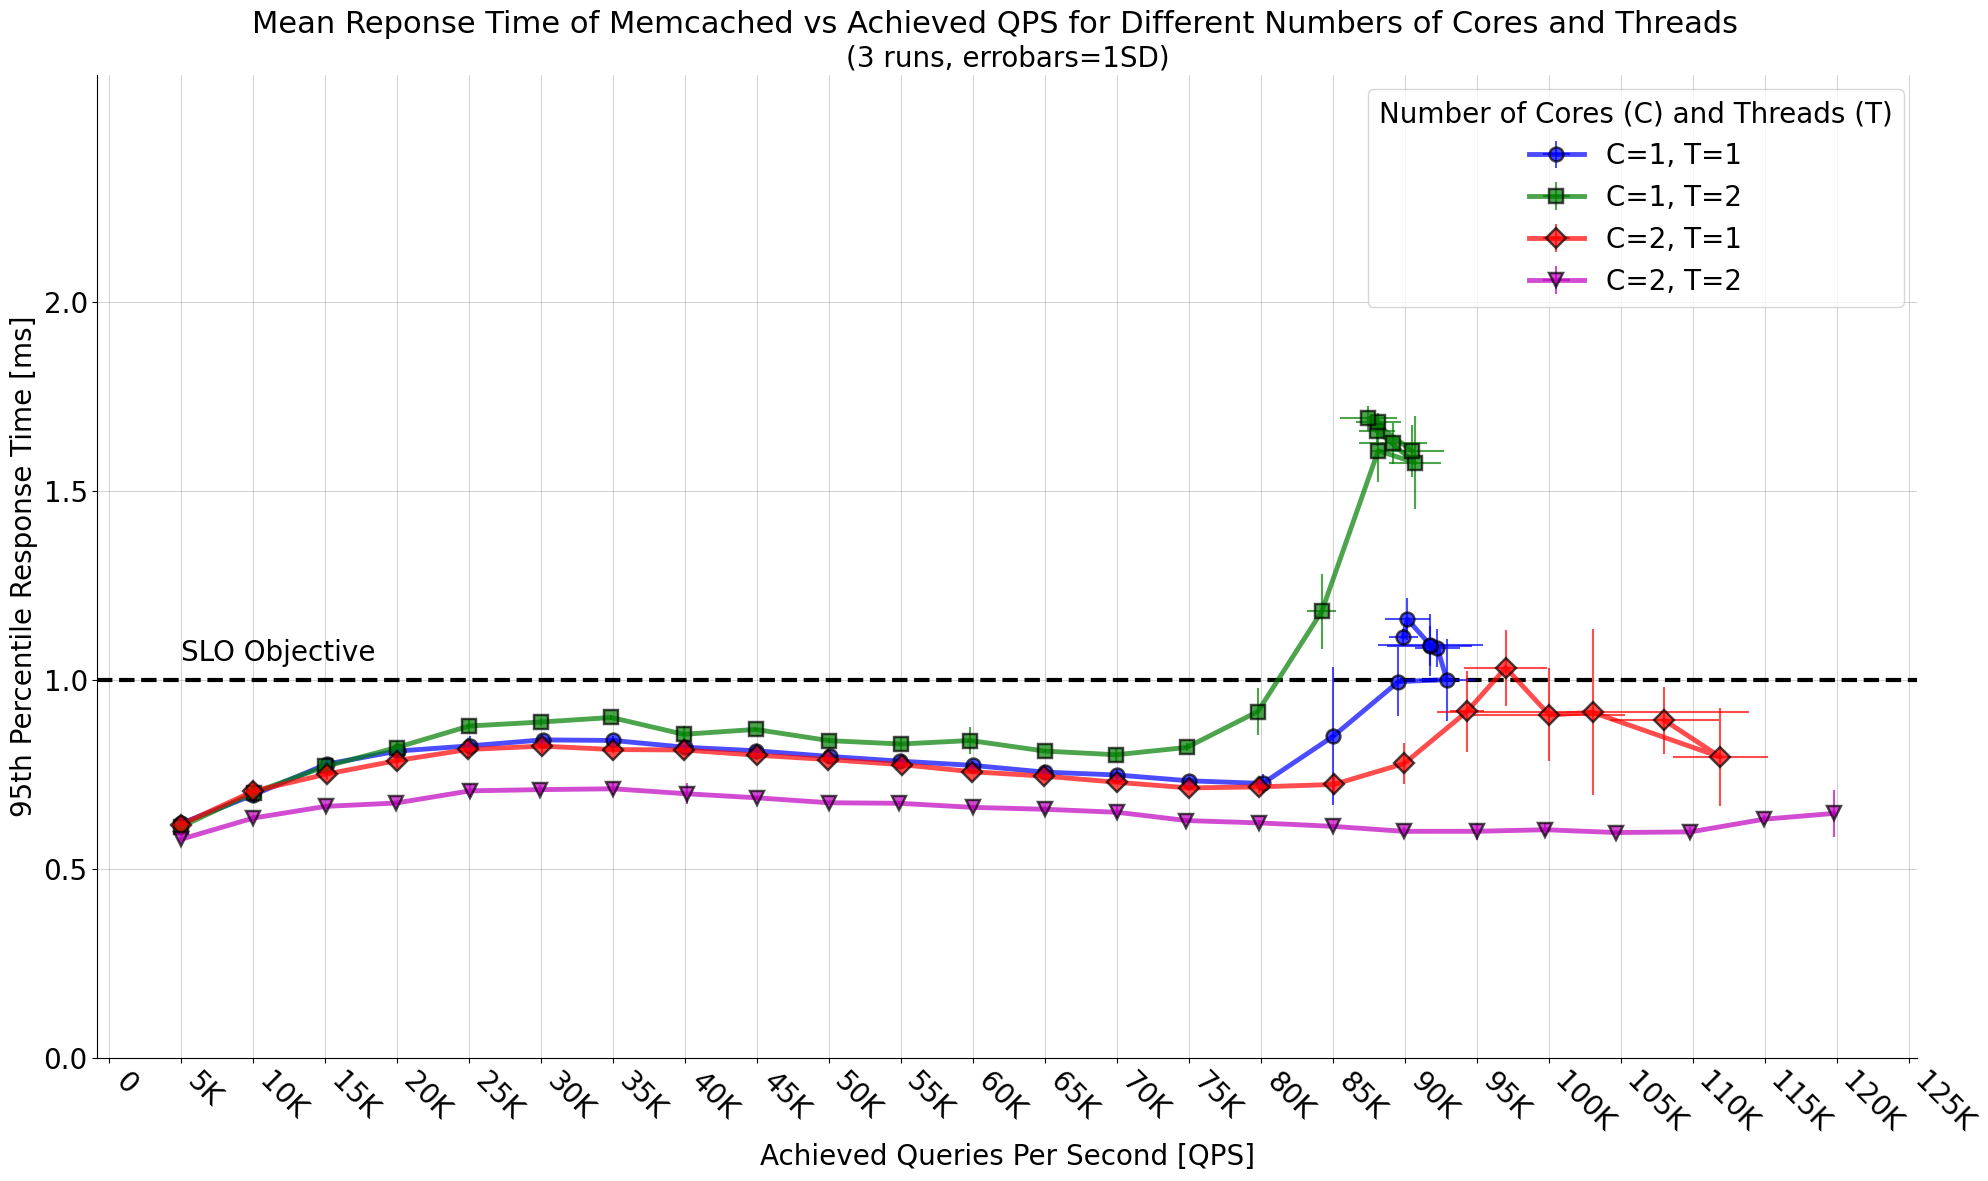

In [5]:
# Plot1a
fig, ax = plt.subplots(figsize=(20, 12))
markers = ['o', 's', 'D', 'v']
colors = [
    '#0000ff',  # blue
    '#007f00',  # green
    '#ff0000',  # red
    '#bf00bf',  # pink
    '#00bfbf',  # light blue
    '#bfbf00',  # ocra
    '#000000',  # black
]
legend_dict = {'C1T1' : 'C=1, T=1', 'C1T2' : 'C=1, T=2', 'C2T1' : 'C=2, T=1', 'C2T2' : 'C=2, T=2'}

slo_objective = ax.axhline(y=1, color='black', linestyle='--', linewidth=3)
ax.annotate('SLO Objective', xy=(5000, 1.05), color='black', fontsize=20)
for i, (CiTi, metrics) in enumerate(metrics_dict.items()):
    ax.errorbar(metrics['avg_QPS'], metrics['avg_p95'], xerr=metrics['std_QPS'], yerr=metrics['std_p95'], marker=markers[i], 
                linewidth=3.5, alpha=0.7, markersize=10, elinewidth=1.5, color=colors[i], markeredgewidth=1.75, 
                markeredgecolor='black', label=legend_dict[CiTi])

# Style
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K', '60K',
            '65K', '70K', '75K', '80K', '85K', '90K', '95K', '100K', '105K', '110K', '115K', '120K', '125K']
ax.set_xticks(range(0, 126000, 5000), x_labels, rotation=-45, ha='left')
ax.set_xlabel('Achieved Queries Per Second [QPS]', fontsize=20)
ax.tick_params(axis='x', labelsize=20)

y_labels = ['0', '0.5', '1', '1.5', '2', '2.5']
ax.set_ylim((0, 2.6))
ax.set_yticks( np.arange(0, 2.5, 0.5).tolist())
ax.set_ylabel('95th Percentile Response Time [ms]', fontsize=20)
ax.tick_params(axis='y', labelsize=20) 

ax.legend(title='Number of Cores (C) and Threads (T)', fontsize=20, title_fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linewidth=0.5, alpha=0.5)
fig.suptitle('Mean Reponse Time of Memcached vs Achieved QPS for Different Numbers of Cores and Threads', fontsize=22)
ax.set_title('(3 runs, errobars=1SD)', fontsize=20)
fig.tight_layout()

plt.show()